<a href="https://colab.research.google.com/github/ravdess/emotion_detection/blob/main/SpeechEmotionDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import required libraries

In [1]:
import os
import librosa
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import librosa
import librosa.display
# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
# Model Traing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
# Model Evaluation
from sklearn.metrics import confusion_matrix
from tensorflow.keras import models as tf_models
from sklearn.metrics import classification_report

## Mounting Dataset from Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')
dataset_root = "/content/drive/MyDrive/data"
dataset_subfolders = ["Audio_Song_Actors_01-24", "Audio_Speech_Actors_01-24"]

Mounted at /content/drive


In [3]:
# Define emotions based on RAVDESS dataset encoding
emotion_map = {'01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
               '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'}

In [4]:
# Ensuring dataset_features directory exists
output_dir = "/content/drive/MyDrive/SpeechEmotionDetection/dataset_features/"
os.makedirs(output_dir, exist_ok=True)

## Feature Extraction

In [5]:
# Function to extract features from an audio file
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)

    # Extract MFCCs
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)

    # Extract Chroma
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)

    # Extract Mel Spectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)

    return np.hstack([mfccs, chroma, mel])

## Dataset Processing

In [6]:
# Function to process a dataset folder
def process_dataset(dataset_path, category, data):
    all_files = []
    for actor_folder in os.listdir(dataset_path):
        actor_path = os.path.join(dataset_path, actor_folder)
        if not os.path.isdir(actor_path):
            continue

        for file_name in os.listdir(actor_path):
            file_path = os.path.join(actor_path, file_name)
            all_files.append((file_path, file_name))

    print(f"Processing {category}: {len(all_files)} files")
    for file_path, file_name in tqdm(all_files, desc=f"{category}"):
        try:
            features = extract_features(file_path)
            emotion_code = file_name.split("-")[2]
            emotion = emotion_map.get(emotion_code, "unknown")
            data.append([file_path, category, emotion] + features.tolist())
        except Exception as e:
            print(f"Error processing {file_name}: {e}")

In [7]:
data = []

for subfolder in dataset_subfolders:
    process_dataset(os.path.join(dataset_root, subfolder), subfolder, data)

if data:
    columns = ["file_path", "category", "emotion"] + [f"feature_{i}" for i in range(len(data[0]) - 3)]
    df = pd.DataFrame(data, columns=columns)

    #Converting Dataframe to csv
    df.to_csv(os.path.join(output_dir, "audio_features.csv"), index=False)
    print("Feature extraction completed! Data saved to dataset_features/audio_features.csv")
else:
    print("No valid audio files found for feature extraction.")


Processing Audio_Song_Actors_01-24: 44 files


Audio_Song_Actors_01-24: 100%|██████████| 44/44 [00:59<00:00,  1.36s/it]


Processing Audio_Speech_Actors_01-24: 76 files


Audio_Speech_Actors_01-24: 100%|██████████| 76/76 [01:13<00:00,  1.04it/s]


Feature extraction completed! Data saved to dataset_features/audio_features.csv


In [8]:
df = pd.read_csv("/content/drive/MyDrive/SpeechEmotionDetection/dataset_features/audio_features.csv")
df.head()

,file_path,category,emotion,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,...,feature_170,feature_171,feature_172,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179
0,/content/drive/MyDrive/data/Audio_Song_Actors_...,Audio_Song_Actors_01-24,neutral,-574.381836,67.309967,-30.840872,-0.162372,-4.934814,-10.494026,-16.890097,...,4.931115e-07,2.266706e-07,1.516844e-07,1.128038e-07,1.238986e-07,9.720392e-08,6.819166e-08,2.761990e-08,8.452344e-09,6.896584e-09
1,/content/drive/MyDrive/data/Audio_Song_Actors_...,Audio_Song_Actors_01-24,neutral,-577.578308,65.770882,-33.157261,-1.443423,-5.831300,-6.498610,-19.072449,...,8.492192e-07,3.160353e-07,2.828727e-07,2.723230e-07,2.116964e-07,1.211949e-07,8.906512e-08,3.217734e-08,8.789963e-09,7.277144e-09
2,/content/drive/MyDrive/data/Audio_Song_Actors_...,Audio_Song_Actors_01-24,calm,-600.616516,65.064606,-22.673502,1.737541,-12.696936,-12.857448,-16.881628,...,9.574217e-07,6.360152e-07,4.583163e-07,3.109663e-07,2.960900e-07,2.574198e-07,1.718454e-07,8.539401e-08,1.333675e-08,7.446569e-09
3,/content/drive/MyDrive/data/Audio_Song_Actors_...,Audio_Song_Actors_01-24,calm,-596.789917,66.608055,-21.163029,3.917316,-12.880773,-14.032175,-17.103786,...,1.374138e-06,9.269112e-07,6.345528e-07,5.491802e-07,5.642018e-07,4.923513e-07,3.847428e-07,1.716314e-07,1.848683e-08,7.934819e-09
4,/content/drive/MyDrive/data/Audio_Song_Actors_...,Audio_Song_Actors_01-24,neutral,-552.644531,60.612236,-35.158916,2.173671,-6.746623,-7.774879,-17.865114,...,3.037660e-06,1.450305e-06,9.042032e-07,8.087686e-07,5.226561e-07,3.008404e-07,2.062918e-07,1.048719e-07,2.053573e-08,7.839788e-09


## Plot the Sample Waveform and MFCC

In [9]:
audio_file = random.choice(df['file_path'])

In [10]:
# Load audio file
y, sr = librosa.load(audio_file, sr=None)

# Compute MFCCs
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)

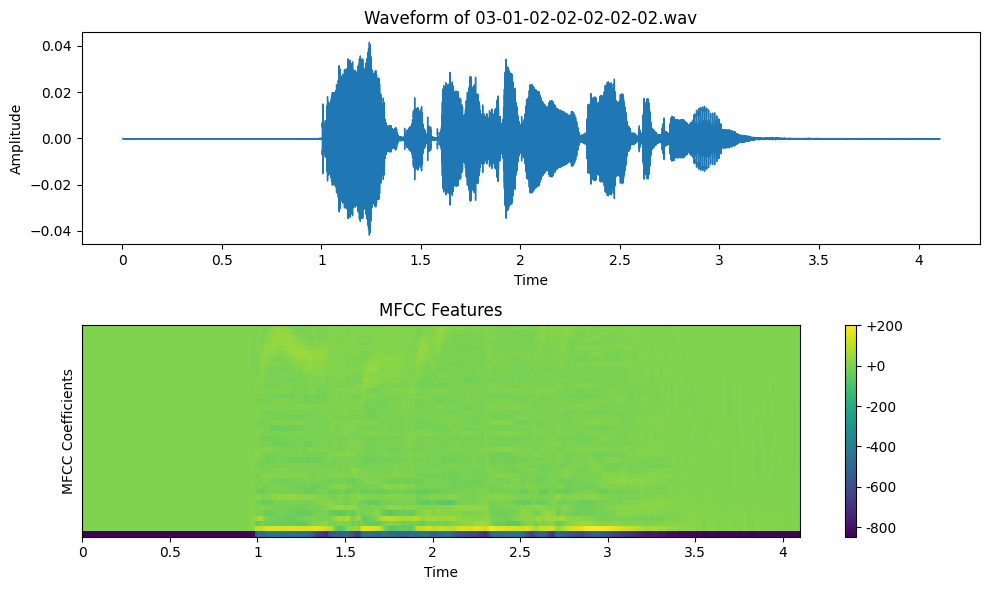

In [11]:
# Create a figure with subplots
fig, ax = plt.subplots(nrows=2, figsize=(10, 6))

# Plot waveform
ax[0].set_title(f"Waveform of {audio_file.split('/')[-1]}")
librosa.display.waveshow(y, sr=sr, ax=ax[0])
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Amplitude")

# Plot MFCC features
img = librosa.display.specshow(mfccs, x_axis="time", sr=sr, ax=ax[1], cmap="viridis")
ax[1].set_title("MFCC Features")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("MFCC Coefficients")
fig.colorbar(img, ax=ax[1], format="%+2.f")
# Show plot
plt.tight_layout()
plt.show()

## Preporcessing Dataset

In [12]:
df.head()

,file_path,category,emotion,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,...,feature_170,feature_171,feature_172,feature_173,feature_174,feature_175,feature_176,feature_177,feature_178,feature_179
0,/content/drive/MyDrive/data/Audio_Song_Actors_...,Audio_Song_Actors_01-24,neutral,-574.381836,67.309967,-30.840872,-0.162372,-4.934814,-10.494026,-16.890097,...,4.931115e-07,2.266706e-07,1.516844e-07,1.128038e-07,1.238986e-07,9.720392e-08,6.819166e-08,2.761990e-08,8.452344e-09,6.896584e-09
1,/content/drive/MyDrive/data/Audio_Song_Actors_...,Audio_Song_Actors_01-24,neutral,-577.578308,65.770882,-33.157261,-1.443423,-5.831300,-6.498610,-19.072449,...,8.492192e-07,3.160353e-07,2.828727e-07,2.723230e-07,2.116964e-07,1.211949e-07,8.906512e-08,3.217734e-08,8.789963e-09,7.277144e-09
2,/content/drive/MyDrive/data/Audio_Song_Actors_...,Audio_Song_Actors_01-24,calm,-600.616516,65.064606,-22.673502,1.737541,-12.696936,-12.857448,-16.881628,...,9.574217e-07,6.360152e-07,4.583163e-07,3.109663e-07,2.960900e-07,2.574198e-07,1.718454e-07,8.539401e-08,1.333675e-08,7.446569e-09
3,/content/drive/MyDrive/data/Audio_Song_Actors_...,Audio_Song_Actors_01-24,calm,-596.789917,66.608055,-21.163029,3.917316,-12.880773,-14.032175,-17.103786,...,1.374138e-06,9.269112e-07,6.345528e-07,5.491802e-07,5.642018e-07,4.923513e-07,3.847428e-07,1.716314e-07,1.848683e-08,7.934819e-09
4,/content/drive/MyDrive/data/Audio_Song_Actors_...,Audio_Song_Actors_01-24,neutral,-552.644531,60.612236,-35.158916,2.173671,-6.746623,-7.774879,-17.865114,...,3.037660e-06,1.450305e-06,9.042032e-07,8.087686e-07,5.226561e-07,3.008404e-07,2.062918e-07,1.048719e-07,2.053573e-08,7.839788e-09


In [13]:
# Encode emotions
label_encoder = LabelEncoder()
df["emotion"] = label_encoder.fit_transform(df["emotion"])

In [14]:
df['emotion'].value_counts()

,count
emotion,
1,22
4,16
6,16
3,16
7,16
5,12
0,12
2,10


In [15]:
# Excluding non-feature columns
exclude_columns = ["emotion", "file_path", "category"]

# Split data into features and labels
X = df.drop(columns=exclude_columns, axis=1)
y = df["emotion"]

In [16]:
# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [17]:
# Split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=28)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((84, 180), (36, 180), (84,), (36,))

In [18]:
np.save(os.path.join(output_dir, "X_train.npy"), X_train)
np.save(os.path.join(output_dir, "X_test.npy"), X_test)
np.save(os.path.join(output_dir, "y_train.npy"), y_train)
np.save(os.path.join(output_dir, "y_test.npy"), y_test)

print("Data preprocessing completed! Datasets saved in dataset_features/")

Data preprocessing completed! Datasets saved in dataset_features/


## Model Training

In [19]:
# Load dataset
dataset_dir = "/content/drive/MyDrive/SpeechEmotionDetection/dataset_features"
X_train = np.load(os.path.join(dataset_dir, "X_train.npy"))
X_test = np.load(os.path.join(dataset_dir, "X_test.npy"))
y_train = np.load(os.path.join(dataset_dir, "y_train.npy"))
y_test = np.load(os.path.join(dataset_dir, "y_test.npy"))

In [20]:
# Define CNN Model
model = Sequential([
    Conv1D(64, kernel_size=3, activation="relu", input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(2),
    Conv1D(128, kernel_size=3, activation="relu"),
    MaxPooling1D(2),
    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.5),
    Dense(len(np.unique(y_train)), activation="softmax")
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
# Compile Model
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 178, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 89, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 87, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 43, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5504)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,409,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,436,296 (5.48 MB)

 Trainable params: 1,436,296 (5.48 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Train Model
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.1949 - loss: 2.0338 - val_accuracy: 0.2500 - val_loss: 1.7851
Epoch 2/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3584 - loss: 1.6527 - val_accuracy: 0.3889 - val_loss: 1.5674
Epoch 3/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4922 - loss: 1.4574 - val_accuracy: 0.5000 - val_loss: 1.3427
Epoch 4/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6140 - loss: 1.1743 - val_accuracy: 0.4722 - val_loss: 1.1945
Epoch 5/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5649 - loss: 1.0940 - val_accuracy: 0.4444 - val_loss: 1.0782
Epoch 6/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6576 - loss: 0.9105 - val_accuracy: 0.5000 - val_loss: 0.9731
Epoch 7/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7734 - loss: 0.7840 - val_accuracy: 0.5278 - val_loss: 0.8653
Epoch 8/30
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7401 - loss: 0.7734 - val_accuracy: 0.6667 - val_loss: 0.8103
Ep

In [33]:
# Save Model
model.save("speech_emotion_model.h5")
print("Model trained and saved!")

Model trained and saved!


## Model Evaluation

In [24]:
# Reshape input
X_test = np.expand_dims(X_test, axis=2)

In [25]:
# Load Saved model
model = tf_models.load_model("speech_emotion_model.h5")

In [26]:
# Predict Output
y_pred = np.argmax(model.predict(X_test), axis=1)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 391ms/step


In [27]:
# Evaluate Print
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.86      0.86      0.86         7
           2       1.00      1.00      1.00         3
           3       0.67      0.50      0.57         4
           4       1.00      1.00      1.00         6
           5       0.60      0.75      0.67         4
           6       0.60      1.00      0.75         3
           7       1.00      0.83      0.91         6

    accuracy                           0.83        36
   macro avg       0.84      0.83      0.82        36
weighted avg       0.86      0.83      0.83        36



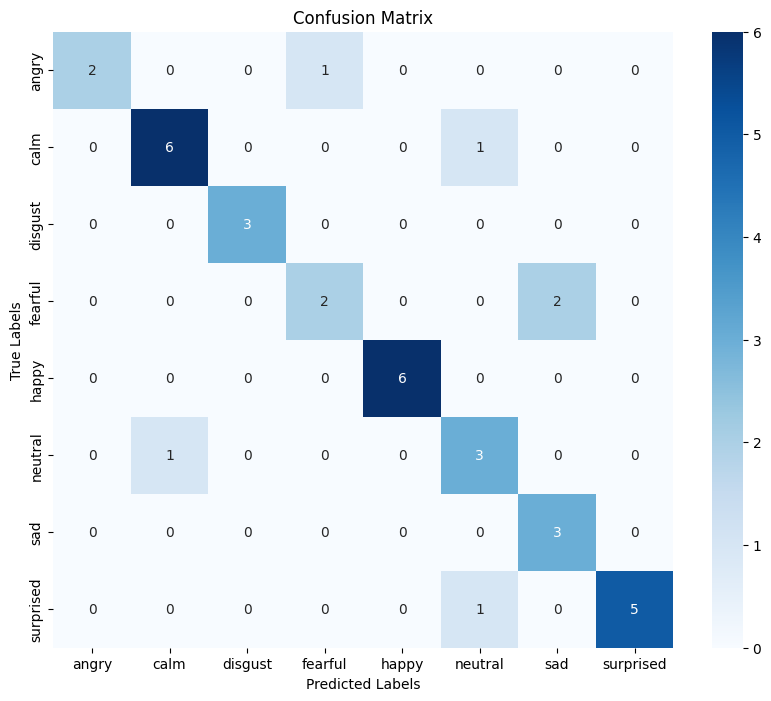

In [28]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()